In [15]:
import numpy as np
from spec_id import Likelihood_contours, Stack_posteriors, Median_w_Error,Oldest_galaxy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from vtl.Readfile import Readfile
from vtl.Photo import Photometry
import pandas as pd
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_3.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [10]:
def Analyze_LH_lwa_Zprior(chifits, specz, metal, age, tau, Zprior,age_conv='../data/light_weight_scaling_3.npy'):
    ####### Get maximum age
    max_age = Oldest_galaxy(specz)

    ####### Read in file
    chi = np.load(chifits).T

    chi[:, len(age[age <= max_age]):, :] = 1E5

    ####### Get scaling factor for tau reshaping
    ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))

    convtable = np.load(age_conv)

    overhead = np.zeros([len(tau),metal.size]).astype(int)
    for i in range(len(tau)):
        for ii in range(metal.size):
            amt=[]
            for iii in range(age.size):
                if age[iii] > convtable.T[i].T[ii][-1]:
                    amt.append(1)
            overhead[i][ii] = sum(amt)

    ######## Reshape likelihood to get average age instead of age when marginalized
    newchi = np.zeros(chi.shape)

    for i in range(len(chi)):
        frame = np.zeros([metal.size,age.size])
        for ii in range(metal.size):
            dist = interp1d(convtable.T[i].T[ii],chi[i].T[ii])(age[:-overhead[i][ii]])
            frame[ii] = np.append(dist,np.repeat(1E5, overhead[i][ii]))
        newchi[i] = frame.T

    ####### Create normalize probablity marginalized over tau
    P = np.exp(-newchi.T.astype(np.float128) / 2)

    ######## Apply metallicity prior
    
    P_p = np.zeros(P.T.shape)
    for i in range(len(tau)):
        for ii in range(age.size):
            P_p[i][ii] = P.T[i][ii]*Zprior
    
    
    prob = np.trapz(P_p.T, ultau, axis=2)
    C = np.trapz(np.trapz(prob, age, axis=1), metal)

    prob /= C

    #### Get Z and t posteriors

    PZ = np.trapz(prob, age, axis=1)
    Pt = np.trapz(prob.T, metal,axis=1)

    return prob.T, PZ,Pt

In [12]:
P,PZ,Pt=Analyze_LH_lwa_Zprior('../chidat/n21156_dtau_chidata.npy',galDB['hi_res_specz'][61],
                          metal,age,tau,PZh,age_conv='../data/light_weight_scaling_3.npy')

In [6]:
"""DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

PZl_grid = Gen_grid(lzDB,'Z')
PZm_grid = Gen_grid(mzDB,'Z')
PZh_grid = Gen_grid(hzDB,'Z')
PZuh_grid = Gen_grid(uhzDB,'Z')

PTl_grid = Gen_grid(lzDB,'t')
PTm_grid = Gen_grid(mzDB,'t')
PTh_grid = Gen_grid(hzDB,'t')
PTuh_grid = Gen_grid(uhzDB,'t')

PZl = Stack_posteriors(PZl_grid,metal)
PZm = Stack_posteriors(PZm_grid,metal)
PZh = Stack_posteriors(PZh_grid,metal)
PZuh = Stack_posteriors(PZuh_grid,metal)

PTl = Stack_posteriors(PTl_grid,age)
PTm = Stack_posteriors(PTm_grid,age)
PTh = Stack_posteriors(PTh_grid,age)
PTuh = Stack_posteriors(PTuh_grid,age)


Zmedl, Zler, Zher = Median_w_Error(PZl, metal)
Zmedm, Zler, Zher = Median_w_Error(PZm, metal)
Zmedh, Zler, Zher = Median_w_Error(PZh, metal)
Zmeduh, Zler, Zher = Median_w_Error(PZuh, metal)
tmedl, tler, ther = Median_w_Error(PTl, age)
tmedm, tler, ther = Median_w_Error(PTm, age)
tmedh, tler, ther = Median_w_Error(PTh, age)
tmeduh, tler, ther = Median_w_Error(PTuh, age)


In [13]:
p = np.load('../chidat/n21156_dtau_tZ_pos_lwa_3.npy')
t,pt = np.load('../chidat/n21156_dtau_t_pos_lwa_3.npy')
Z,pZ = np.load('../chidat/n21156_dtau_Z_pos_lwa_3.npy')
onesig,twosig = Likelihood_contours(age,metal,P)
Levels = np.array([twosig,onesig])
onesig,twosig = Likelihood_contours(age,metal,p)
levels = np.array([twosig,onesig])

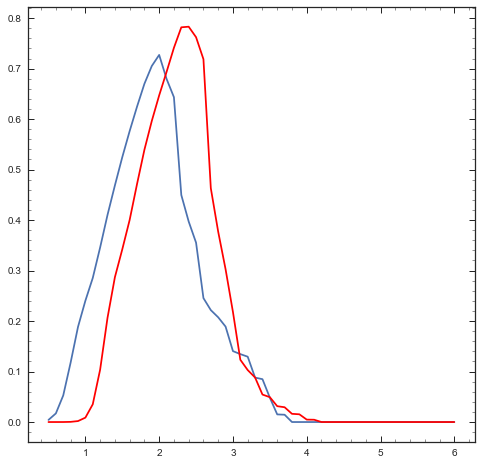

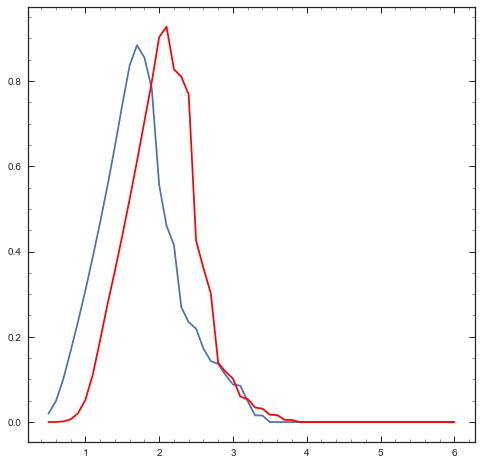

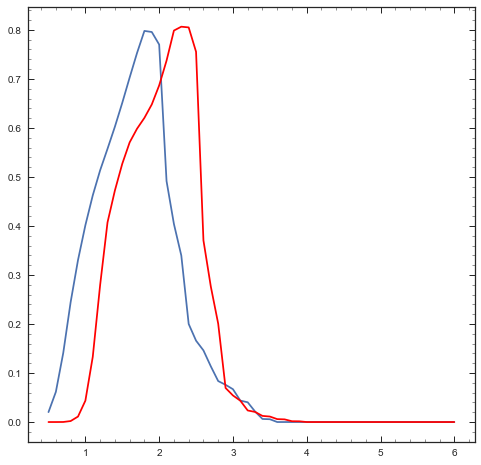

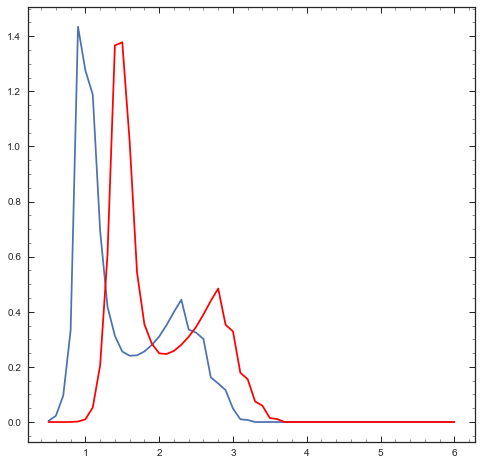

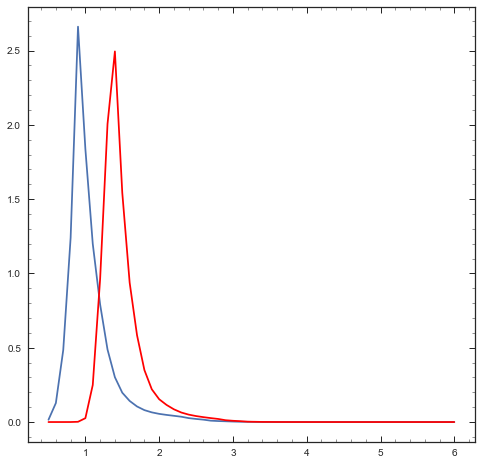

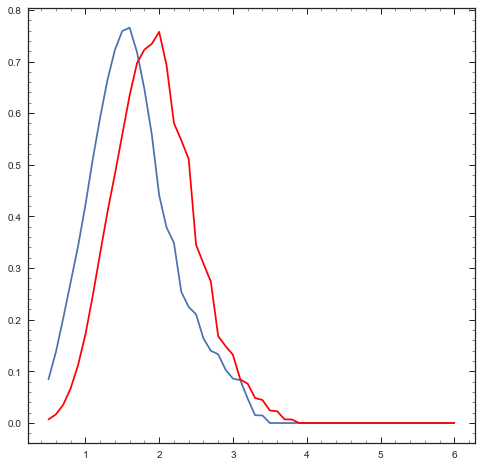

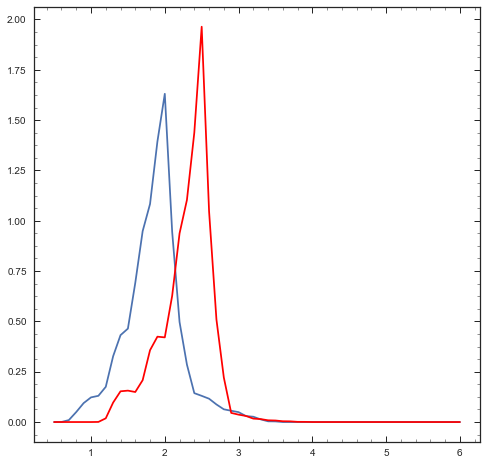

In [30]:
%matplotlib inline

newgridZ=[]
newgridt=[]
for i in uhzDB.index:

    P,PZ,Pt=Analyze_LH_lwa_Zprior('../chidat/%s_dtau_chidata.npy' % uhzDB['gids'][i],uhzDB['hi_res_specz'][i],
                              metal,age,tau,PZh,age_conv='../data/light_weight_scaling_3.npy')
    t,pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % uhzDB['gids'][i])

    plt.figure(figsize=[8,8])
    plt.plot(age,pt)
    plt.plot(age,Pt,'r')
    
    newgridZ.append(PZ)
    newgridt.append(Pt)

In [23]:
nPZuh = Stack_posteriors(newgridZ,metal)
nPTuh = Stack_posteriors(newgridt,age)

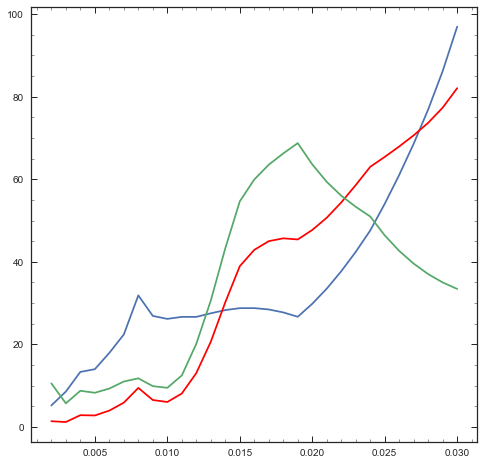

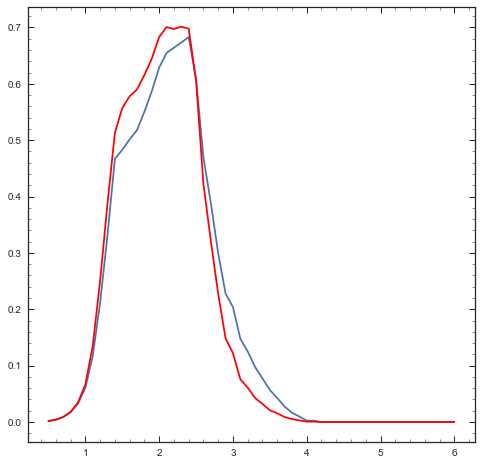

In [29]:
plt.figure(figsize=[8,8])
plt.plot(metal,PZuh)
plt.plot(metal,nPZuh,'r')
plt.plot(metal,PZh)


plt.figure(figsize=[8,8])
plt.plot(age,PTuh)
plt.plot(age,nPTuh,'r')